# Exp1 Re-implement DCGAN

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64

In [2]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 64 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 50
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# dataloader
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
criterion = nn.BCELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [10,25], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [10,25], gamma=0.1)

202599
Generator_64(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

In [4]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)
    
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        
        #forward
        real_output = net_D(real_data).view(-1)
        fake_output = net_D(fake_data.detach()).view(-1)
        real_loss_D = criterion(real_output, real_label)
        fake_loss_D = criterion(fake_output, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        fake_output_G = net_D(fake_data).view(-1)
        loss_G = criterion(fake_output_G, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp1/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [5]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/50] Iter:1  Loss_D=1.5223 Loss_G=2.2532 D(x)=0.3612 D(G(z))=0.2490, 0.1340
[0/50] Iter:51  Loss_D=0.2855 Loss_G=22.6095 D(x)=0.8930 D(G(z))=0.0000, 0.0000
[0/50] Iter:101  Loss_D=0.0001 Loss_G=36.4096 D(x)=0.9999 D(G(z))=0.0000, 0.0000
[0/50] Iter:151  Loss_D=0.0002 Loss_G=32.3181 D(x)=0.9998 D(G(z))=0.0000, 0.0000
[0/50] Iter:201  Loss_D=0.3515 Loss_G=2.4226 D(x)=0.8296 D(G(z))=0.0431, 0.1761
[0/50] Iter:251  Loss_D=0.5297 Loss_G=6.3718 D(x)=0.7871 D(G(z))=0.1716, 0.0048
[0/50] Iter:301  Loss_D=1.2486 Loss_G=2.7643 D(x)=0.4412 D(G(z))=0.0341, 0.1194
[0/50] Iter:351  Loss_D=0.9550 Loss_G=1.8080 D(x)=0.5513 D(G(z))=0.0898, 0.3327
[0/50] Iter:401  Loss_D=1.7092 Loss_G=8.3115 D(x)=0.9556 D(G(z))=0.6814, 0.0010
[0/50] Iter:451  Loss_D=0.5496 Loss_G=3.4523 D(x)=0.6787 D(G(z))=0.0454, 0.0518
[0/50] Iter:501  Loss_D=0.2548 Loss_G=5.8625 D(x)=0.8501 D(G(z))=0.0529, 0.0063
[0/50] Iter:551  Loss_D=0.4212 Loss_G=4.0509 D(x)=0.7587 D(G(z))=0.0589, 0.0370
[0/50] Iter:601  Loss_D=0.4579 Loss_G=3.

[3/50] Iter:351  Loss_D=0.5156 Loss_G=2.4967 D(x)=0.8435 D(G(z))=0.2600, 0.1094
[3/50] Iter:401  Loss_D=0.5557 Loss_G=2.8176 D(x)=0.8579 D(G(z))=0.3012, 0.0784
[3/50] Iter:451  Loss_D=0.5646 Loss_G=1.6477 D(x)=0.6797 D(G(z))=0.1218, 0.2373
[3/50] Iter:501  Loss_D=0.4678 Loss_G=2.9493 D(x)=0.8045 D(G(z))=0.1899, 0.0743
[3/50] Iter:551  Loss_D=0.5040 Loss_G=2.4064 D(x)=0.7920 D(G(z))=0.2112, 0.1149
[3/50] Iter:601  Loss_D=0.5235 Loss_G=2.8672 D(x)=0.7980 D(G(z))=0.2223, 0.0733
[3/50] Iter:651  Loss_D=0.7110 Loss_G=3.4438 D(x)=0.8630 D(G(z))=0.3930, 0.0417
[3/50] Iter:701  Loss_D=0.4959 Loss_G=2.6486 D(x)=0.7543 D(G(z))=0.1543, 0.0948
[3/50] Iter:751  Loss_D=0.6281 Loss_G=2.7490 D(x)=0.8354 D(G(z))=0.3226, 0.0831
[3/50] Iter:801  Loss_D=0.6300 Loss_G=1.8059 D(x)=0.6619 D(G(z))=0.1361, 0.1984
[3/50] Iter:851  Loss_D=0.4413 Loss_G=2.6153 D(x)=0.8220 D(G(z))=0.1889, 0.0913
[3/50] Iter:901  Loss_D=0.8865 Loss_G=1.7513 D(x)=0.5790 D(G(z))=0.2148, 0.2229
[3/50] Iter:951  Loss_D=0.6592 Loss_G=3.

[6/50] Iter:701  Loss_D=0.4835 Loss_G=1.4363 D(x)=0.7355 D(G(z))=0.1327, 0.2917
[6/50] Iter:751  Loss_D=1.1967 Loss_G=5.9613 D(x)=0.9343 D(G(z))=0.6147, 0.0047
[6/50] Iter:801  Loss_D=0.5333 Loss_G=1.9487 D(x)=0.7075 D(G(z))=0.1281, 0.1738
[6/50] Iter:851  Loss_D=0.4150 Loss_G=2.3519 D(x)=0.7850 D(G(z))=0.1337, 0.1264
[6/50] Iter:901  Loss_D=0.6405 Loss_G=2.8147 D(x)=0.9111 D(G(z))=0.3729, 0.0813
[6/50] Iter:951  Loss_D=1.1278 Loss_G=2.6481 D(x)=0.7098 D(G(z))=0.4659, 0.1012
[6/50] Iter:1001  Loss_D=0.6764 Loss_G=2.0088 D(x)=0.5756 D(G(z))=0.0481, 0.1716
[6/50] Iter:1051  Loss_D=1.1452 Loss_G=0.0725 D(x)=0.3895 D(G(z))=0.0438, 0.9342
[6/50] Iter:1101  Loss_D=0.5099 Loss_G=2.4064 D(x)=0.7857 D(G(z))=0.1951, 0.1261
[6/50] Iter:1151  Loss_D=0.4632 Loss_G=2.2298 D(x)=0.7274 D(G(z))=0.1038, 0.1392
[6/50] Iter:1201  Loss_D=0.5362 Loss_G=2.3007 D(x)=0.7536 D(G(z))=0.1714, 0.1244
[6/50] Iter:1251  Loss_D=0.8125 Loss_G=1.8686 D(x)=0.6955 D(G(z))=0.2903, 0.1975
[6/50] Iter:1301  Loss_D=0.6026 Lo

[9/50] Iter:1051  Loss_D=0.8019 Loss_G=1.2645 D(x)=0.5216 D(G(z))=0.0405, 0.3458
[9/50] Iter:1101  Loss_D=0.3507 Loss_G=2.5587 D(x)=0.7678 D(G(z))=0.0478, 0.1033
[9/50] Iter:1151  Loss_D=1.0907 Loss_G=4.7459 D(x)=0.9736 D(G(z))=0.5906, 0.0157
[9/50] Iter:1201  Loss_D=0.3726 Loss_G=2.3822 D(x)=0.7704 D(G(z))=0.0773, 0.1296
[9/50] Iter:1251  Loss_D=0.3485 Loss_G=2.4169 D(x)=0.8114 D(G(z))=0.1059, 0.1125
[9/50] Iter:1301  Loss_D=0.5808 Loss_G=1.4962 D(x)=0.6733 D(G(z))=0.1106, 0.2874
[9/50] Iter:1351  Loss_D=0.2877 Loss_G=3.2299 D(x)=0.8926 D(G(z))=0.1418, 0.0586
[9/50] Iter:1401  Loss_D=0.3827 Loss_G=3.2920 D(x)=0.8831 D(G(z))=0.2012, 0.0529
[9/50] Iter:1451  Loss_D=0.3782 Loss_G=2.5403 D(x)=0.7808 D(G(z))=0.0900, 0.1045
[9/50] Iter:1501  Loss_D=0.2692 Loss_G=2.8233 D(x)=0.8480 D(G(z))=0.0764, 0.0847
[9/50] Iter:1551  Loss_D=0.4077 Loss_G=2.7812 D(x)=0.8319 D(G(z))=0.1704, 0.0842
[10/50] Iter:1  Loss_D=1.2518 Loss_G=1.0406 D(x)=0.9897 D(G(z))=0.6272, 0.4480
[10/50] Iter:51  Loss_D=0.1787

[12/50] Iter:1301  Loss_D=0.1475 Loss_G=3.3020 D(x)=0.9069 D(G(z))=0.0411, 0.0558
[12/50] Iter:1351  Loss_D=0.1189 Loss_G=3.5232 D(x)=0.9379 D(G(z))=0.0492, 0.0474
[12/50] Iter:1401  Loss_D=0.1162 Loss_G=3.5940 D(x)=0.9419 D(G(z))=0.0497, 0.0474
[12/50] Iter:1451  Loss_D=0.1158 Loss_G=3.6242 D(x)=0.9366 D(G(z))=0.0449, 0.0390
[12/50] Iter:1501  Loss_D=0.1299 Loss_G=3.7782 D(x)=0.9228 D(G(z))=0.0417, 0.0411
[12/50] Iter:1551  Loss_D=0.0892 Loss_G=4.0496 D(x)=0.9586 D(G(z))=0.0432, 0.0307
[13/50] Iter:1  Loss_D=0.1309 Loss_G=3.5685 D(x)=0.9748 D(G(z))=0.0928, 0.0480
[13/50] Iter:51  Loss_D=0.1087 Loss_G=3.7508 D(x)=0.9648 D(G(z))=0.0665, 0.0369
[13/50] Iter:101  Loss_D=0.1006 Loss_G=3.6540 D(x)=0.9387 D(G(z))=0.0303, 0.0421
[13/50] Iter:151  Loss_D=0.0984 Loss_G=3.7906 D(x)=0.9808 D(G(z))=0.0709, 0.0373
[13/50] Iter:201  Loss_D=0.0705 Loss_G=3.8987 D(x)=0.9601 D(G(z))=0.0277, 0.0340
[13/50] Iter:251  Loss_D=0.1962 Loss_G=2.7925 D(x)=0.8798 D(G(z))=0.0549, 0.0936
[13/50] Iter:301  Loss_D=

[15/50] Iter:1551  Loss_D=0.0331 Loss_G=5.1672 D(x)=0.9842 D(G(z))=0.0165, 0.0122
[16/50] Iter:1  Loss_D=0.0455 Loss_G=4.5498 D(x)=0.9794 D(G(z))=0.0235, 0.0189
[16/50] Iter:51  Loss_D=0.0517 Loss_G=4.8258 D(x)=0.9746 D(G(z))=0.0238, 0.0179
[16/50] Iter:101  Loss_D=0.0237 Loss_G=5.1694 D(x)=0.9912 D(G(z))=0.0142, 0.0123
[16/50] Iter:151  Loss_D=0.0318 Loss_G=4.8330 D(x)=0.9889 D(G(z))=0.0202, 0.0137
[16/50] Iter:201  Loss_D=0.0485 Loss_G=4.9601 D(x)=0.9935 D(G(z))=0.0392, 0.0143
[16/50] Iter:251  Loss_D=0.0505 Loss_G=4.6705 D(x)=0.9719 D(G(z))=0.0202, 0.0197
[16/50] Iter:301  Loss_D=0.0621 Loss_G=4.4590 D(x)=0.9614 D(G(z))=0.0202, 0.0232
[16/50] Iter:351  Loss_D=0.0343 Loss_G=5.1276 D(x)=0.9809 D(G(z))=0.0144, 0.0123
[16/50] Iter:401  Loss_D=0.0814 Loss_G=3.8174 D(x)=0.9387 D(G(z))=0.0150, 0.0464
[16/50] Iter:451  Loss_D=0.0577 Loss_G=4.8340 D(x)=0.9780 D(G(z))=0.0335, 0.0162
[16/50] Iter:501  Loss_D=0.0494 Loss_G=4.4982 D(x)=0.9668 D(G(z))=0.0144, 0.0225
[16/50] Iter:551  Loss_D=0.046

[19/50] Iter:201  Loss_D=0.0366 Loss_G=4.7822 D(x)=0.9793 D(G(z))=0.0147, 0.0175
[19/50] Iter:251  Loss_D=0.0360 Loss_G=5.2993 D(x)=0.9795 D(G(z))=0.0137, 0.0122
[19/50] Iter:301  Loss_D=0.0467 Loss_G=4.5805 D(x)=0.9825 D(G(z))=0.0274, 0.0221
[19/50] Iter:351  Loss_D=0.0266 Loss_G=5.1083 D(x)=0.9897 D(G(z))=0.0157, 0.0129
[19/50] Iter:401  Loss_D=0.0571 Loss_G=4.6625 D(x)=0.9612 D(G(z))=0.0156, 0.0219
[19/50] Iter:451  Loss_D=0.0422 Loss_G=4.9172 D(x)=0.9920 D(G(z))=0.0321, 0.0166
[19/50] Iter:501  Loss_D=0.0322 Loss_G=5.3486 D(x)=0.9821 D(G(z))=0.0135, 0.0119
[19/50] Iter:551  Loss_D=0.0317 Loss_G=5.4013 D(x)=0.9757 D(G(z))=0.0066, 0.0094
[19/50] Iter:601  Loss_D=0.0367 Loss_G=5.1400 D(x)=0.9882 D(G(z))=0.0232, 0.0143
[19/50] Iter:651  Loss_D=0.0406 Loss_G=4.9398 D(x)=0.9698 D(G(z))=0.0090, 0.0140
[19/50] Iter:701  Loss_D=0.0267 Loss_G=5.5287 D(x)=0.9858 D(G(z))=0.0119, 0.0105
[19/50] Iter:751  Loss_D=0.0480 Loss_G=5.1462 D(x)=0.9616 D(G(z))=0.0074, 0.0136
[19/50] Iter:801  Loss_D=0.0

[22/50] Iter:451  Loss_D=0.1242 Loss_G=4.5464 D(x)=0.9093 D(G(z))=0.0171, 0.0246
[22/50] Iter:501  Loss_D=0.0388 Loss_G=5.0499 D(x)=0.9798 D(G(z))=0.0175, 0.0161
[22/50] Iter:551  Loss_D=0.0278 Loss_G=5.3580 D(x)=0.9865 D(G(z))=0.0137, 0.0124
[22/50] Iter:601  Loss_D=0.0272 Loss_G=5.4607 D(x)=0.9825 D(G(z))=0.0091, 0.0098
[22/50] Iter:651  Loss_D=0.0415 Loss_G=4.8478 D(x)=0.9852 D(G(z))=0.0244, 0.0213
[22/50] Iter:701  Loss_D=0.0268 Loss_G=5.3131 D(x)=0.9932 D(G(z))=0.0193, 0.0133
[22/50] Iter:751  Loss_D=0.0322 Loss_G=5.2706 D(x)=0.9898 D(G(z))=0.0205, 0.0137
[22/50] Iter:801  Loss_D=0.0381 Loss_G=5.2857 D(x)=0.9828 D(G(z))=0.0180, 0.0137
[22/50] Iter:851  Loss_D=0.0176 Loss_G=5.5258 D(x)=0.9967 D(G(z))=0.0139, 0.0111
[22/50] Iter:901  Loss_D=0.0232 Loss_G=5.3341 D(x)=0.9900 D(G(z))=0.0126, 0.0126
[22/50] Iter:951  Loss_D=0.0311 Loss_G=5.1362 D(x)=0.9841 D(G(z))=0.0146, 0.0122
[22/50] Iter:1001  Loss_D=0.0327 Loss_G=5.3622 D(x)=0.9845 D(G(z))=0.0161, 0.0129
[22/50] Iter:1051  Loss_D=0

[25/50] Iter:701  Loss_D=0.0306 Loss_G=5.4966 D(x)=0.9841 D(G(z))=0.0138, 0.0131
[25/50] Iter:751  Loss_D=0.0245 Loss_G=5.4182 D(x)=0.9875 D(G(z))=0.0115, 0.0119
[25/50] Iter:801  Loss_D=0.0424 Loss_G=5.1887 D(x)=0.9733 D(G(z))=0.0142, 0.0146
[25/50] Iter:851  Loss_D=0.0341 Loss_G=5.1438 D(x)=0.9836 D(G(z))=0.0167, 0.0172
[25/50] Iter:901  Loss_D=0.0208 Loss_G=5.3444 D(x)=0.9969 D(G(z))=0.0170, 0.0155
[25/50] Iter:951  Loss_D=0.0329 Loss_G=5.1965 D(x)=0.9841 D(G(z))=0.0159, 0.0155
[25/50] Iter:1001  Loss_D=0.0295 Loss_G=5.5677 D(x)=0.9824 D(G(z))=0.0111, 0.0112
[25/50] Iter:1051  Loss_D=0.0186 Loss_G=5.7657 D(x)=0.9901 D(G(z))=0.0084, 0.0083
[25/50] Iter:1101  Loss_D=0.0176 Loss_G=5.5739 D(x)=0.9956 D(G(z))=0.0127, 0.0120
[25/50] Iter:1151  Loss_D=0.0226 Loss_G=5.4948 D(x)=0.9897 D(G(z))=0.0118, 0.0113
[25/50] Iter:1201  Loss_D=0.0281 Loss_G=5.6881 D(x)=0.9802 D(G(z))=0.0075, 0.0079
[25/50] Iter:1251  Loss_D=0.0297 Loss_G=5.1388 D(x)=0.9865 D(G(z))=0.0153, 0.0148
[25/50] Iter:1301  Los

[28/50] Iter:951  Loss_D=0.0274 Loss_G=5.3403 D(x)=0.9902 D(G(z))=0.0166, 0.0162
[28/50] Iter:1001  Loss_D=0.0294 Loss_G=5.5591 D(x)=0.9855 D(G(z))=0.0140, 0.0127
[28/50] Iter:1051  Loss_D=0.0314 Loss_G=5.3093 D(x)=0.9930 D(G(z))=0.0228, 0.0184
[28/50] Iter:1101  Loss_D=0.0222 Loss_G=5.1194 D(x)=0.9941 D(G(z))=0.0159, 0.0142
[28/50] Iter:1151  Loss_D=0.0297 Loss_G=6.0312 D(x)=0.9764 D(G(z))=0.0052, 0.0060
[28/50] Iter:1201  Loss_D=0.0476 Loss_G=5.3496 D(x)=0.9646 D(G(z))=0.0103, 0.0122
[28/50] Iter:1251  Loss_D=0.0141 Loss_G=6.0407 D(x)=0.9935 D(G(z))=0.0074, 0.0070
[28/50] Iter:1301  Loss_D=0.0136 Loss_G=5.6685 D(x)=0.9989 D(G(z))=0.0122, 0.0103
[28/50] Iter:1351  Loss_D=0.0269 Loss_G=5.6959 D(x)=0.9877 D(G(z))=0.0134, 0.0120
[28/50] Iter:1401  Loss_D=0.0204 Loss_G=5.7935 D(x)=0.9893 D(G(z))=0.0092, 0.0087
[28/50] Iter:1451  Loss_D=0.0125 Loss_G=6.3005 D(x)=0.9936 D(G(z))=0.0060, 0.0055
[28/50] Iter:1501  Loss_D=0.0388 Loss_G=5.1525 D(x)=0.9765 D(G(z))=0.0140, 0.0148
[28/50] Iter:1551

[31/50] Iter:1201  Loss_D=0.0209 Loss_G=6.4946 D(x)=0.9857 D(G(z))=0.0061, 0.0059
[31/50] Iter:1251  Loss_D=0.0175 Loss_G=6.1297 D(x)=0.9890 D(G(z))=0.0062, 0.0063
[31/50] Iter:1301  Loss_D=0.0400 Loss_G=4.9780 D(x)=0.9799 D(G(z))=0.0185, 0.0175
[31/50] Iter:1351  Loss_D=0.0226 Loss_G=6.3213 D(x)=0.9840 D(G(z))=0.0060, 0.0065
[31/50] Iter:1401  Loss_D=0.0207 Loss_G=5.4994 D(x)=0.9932 D(G(z))=0.0135, 0.0113
[31/50] Iter:1451  Loss_D=0.0260 Loss_G=6.4030 D(x)=0.9806 D(G(z))=0.0058, 0.0062
[31/50] Iter:1501  Loss_D=0.0192 Loss_G=6.1236 D(x)=0.9910 D(G(z))=0.0096, 0.0088
[31/50] Iter:1551  Loss_D=0.0198 Loss_G=5.9298 D(x)=0.9871 D(G(z))=0.0066, 0.0068
[32/50] Iter:1  Loss_D=0.0154 Loss_G=6.0422 D(x)=0.9936 D(G(z))=0.0088, 0.0081
[32/50] Iter:51  Loss_D=0.0260 Loss_G=5.4518 D(x)=0.9911 D(G(z))=0.0163, 0.0147
[32/50] Iter:101  Loss_D=0.0111 Loss_G=6.9154 D(x)=0.9918 D(G(z))=0.0027, 0.0028
[32/50] Iter:151  Loss_D=0.0118 Loss_G=6.0368 D(x)=0.9946 D(G(z))=0.0063, 0.0061
[32/50] Iter:201  Loss_

[34/50] Iter:1451  Loss_D=0.0113 Loss_G=6.1404 D(x)=0.9969 D(G(z))=0.0080, 0.0072
[34/50] Iter:1501  Loss_D=0.0104 Loss_G=6.6556 D(x)=0.9941 D(G(z))=0.0043, 0.0043
[34/50] Iter:1551  Loss_D=0.0129 Loss_G=6.1131 D(x)=0.9936 D(G(z))=0.0064, 0.0062
[35/50] Iter:1  Loss_D=0.0114 Loss_G=5.8071 D(x)=0.9949 D(G(z))=0.0062, 0.0062
[35/50] Iter:51  Loss_D=0.0215 Loss_G=6.0574 D(x)=0.9911 D(G(z))=0.0112, 0.0094
[35/50] Iter:101  Loss_D=0.0128 Loss_G=6.0542 D(x)=0.9966 D(G(z))=0.0092, 0.0082
[35/50] Iter:151  Loss_D=0.0133 Loss_G=5.8415 D(x)=0.9967 D(G(z))=0.0097, 0.0092
[35/50] Iter:201  Loss_D=0.0159 Loss_G=5.5196 D(x)=0.9966 D(G(z))=0.0121, 0.0107
[35/50] Iter:251  Loss_D=0.0113 Loss_G=5.9501 D(x)=0.9972 D(G(z))=0.0084, 0.0076
[35/50] Iter:301  Loss_D=0.0295 Loss_G=5.9122 D(x)=0.9932 D(G(z))=0.0145, 0.0107
[35/50] Iter:351  Loss_D=0.0142 Loss_G=6.5285 D(x)=0.9901 D(G(z))=0.0042, 0.0045
[35/50] Iter:401  Loss_D=0.0161 Loss_G=6.2351 D(x)=0.9922 D(G(z))=0.0079, 0.0073
[35/50] Iter:451  Loss_D=0.0

[38/50] Iter:101  Loss_D=0.0135 Loss_G=6.3287 D(x)=0.9942 D(G(z))=0.0075, 0.0066
[38/50] Iter:151  Loss_D=0.0142 Loss_G=6.4370 D(x)=0.9903 D(G(z))=0.0043, 0.0045
[38/50] Iter:201  Loss_D=0.0216 Loss_G=6.1641 D(x)=0.9925 D(G(z))=0.0126, 0.0103
[38/50] Iter:251  Loss_D=0.0139 Loss_G=6.1151 D(x)=0.9919 D(G(z))=0.0057, 0.0053
[38/50] Iter:301  Loss_D=0.0130 Loss_G=6.4792 D(x)=0.9907 D(G(z))=0.0035, 0.0037
[38/50] Iter:351  Loss_D=0.0101 Loss_G=6.3595 D(x)=0.9962 D(G(z))=0.0062, 0.0058
[38/50] Iter:401  Loss_D=0.0162 Loss_G=6.4670 D(x)=0.9889 D(G(z))=0.0049, 0.0053
[38/50] Iter:451  Loss_D=0.0201 Loss_G=6.1693 D(x)=0.9886 D(G(z))=0.0083, 0.0078
[38/50] Iter:501  Loss_D=0.0119 Loss_G=6.5010 D(x)=0.9948 D(G(z))=0.0065, 0.0061
[38/50] Iter:551  Loss_D=0.0225 Loss_G=5.7498 D(x)=0.9865 D(G(z))=0.0085, 0.0090
[38/50] Iter:601  Loss_D=0.0139 Loss_G=6.3312 D(x)=0.9933 D(G(z))=0.0068, 0.0065
[38/50] Iter:651  Loss_D=0.0139 Loss_G=5.8061 D(x)=0.9953 D(G(z))=0.0091, 0.0085
[38/50] Iter:701  Loss_D=0.0

[41/50] Iter:351  Loss_D=0.0108 Loss_G=6.7766 D(x)=0.9930 D(G(z))=0.0037, 0.0039
[41/50] Iter:401  Loss_D=0.0150 Loss_G=6.1420 D(x)=0.9910 D(G(z))=0.0058, 0.0058
[41/50] Iter:451  Loss_D=0.0098 Loss_G=6.0138 D(x)=0.9992 D(G(z))=0.0087, 0.0072
[41/50] Iter:501  Loss_D=0.0114 Loss_G=6.8837 D(x)=0.9920 D(G(z))=0.0033, 0.0035
[41/50] Iter:551  Loss_D=0.0222 Loss_G=5.7632 D(x)=0.9923 D(G(z))=0.0124, 0.0125
[41/50] Iter:601  Loss_D=0.0073 Loss_G=6.4941 D(x)=0.9985 D(G(z))=0.0058, 0.0050
[41/50] Iter:651  Loss_D=0.0299 Loss_G=6.1803 D(x)=0.9757 D(G(z))=0.0046, 0.0056
[41/50] Iter:701  Loss_D=0.0155 Loss_G=6.3131 D(x)=0.9914 D(G(z))=0.0065, 0.0063
[41/50] Iter:751  Loss_D=0.0092 Loss_G=6.3489 D(x)=0.9960 D(G(z))=0.0050, 0.0047
[41/50] Iter:801  Loss_D=0.0123 Loss_G=6.3272 D(x)=0.9934 D(G(z))=0.0056, 0.0055
[41/50] Iter:851  Loss_D=0.0106 Loss_G=6.1886 D(x)=0.9983 D(G(z))=0.0088, 0.0077
[41/50] Iter:901  Loss_D=0.0156 Loss_G=5.7924 D(x)=0.9919 D(G(z))=0.0073, 0.0075
[41/50] Iter:951  Loss_D=0.0

[44/50] Iter:601  Loss_D=0.0165 Loss_G=6.4083 D(x)=0.9880 D(G(z))=0.0042, 0.0048
[44/50] Iter:651  Loss_D=0.0161 Loss_G=6.3949 D(x)=0.9896 D(G(z))=0.0054, 0.0055
[44/50] Iter:701  Loss_D=0.0115 Loss_G=6.8724 D(x)=0.9915 D(G(z))=0.0028, 0.0031
[44/50] Iter:751  Loss_D=0.0043 Loss_G=7.0320 D(x)=0.9991 D(G(z))=0.0033, 0.0029
[44/50] Iter:801  Loss_D=0.0122 Loss_G=6.0704 D(x)=0.9948 D(G(z))=0.0069, 0.0063
[44/50] Iter:851  Loss_D=0.0146 Loss_G=6.0506 D(x)=0.9933 D(G(z))=0.0076, 0.0074
[44/50] Iter:901  Loss_D=0.0183 Loss_G=5.2939 D(x)=0.9965 D(G(z))=0.0144, 0.0114
[44/50] Iter:951  Loss_D=0.0176 Loss_G=6.2455 D(x)=0.9892 D(G(z))=0.0065, 0.0066
[44/50] Iter:1001  Loss_D=0.0100 Loss_G=6.4615 D(x)=0.9951 D(G(z))=0.0050, 0.0049
[44/50] Iter:1051  Loss_D=0.0145 Loss_G=6.6403 D(x)=0.9900 D(G(z))=0.0043, 0.0043
[44/50] Iter:1101  Loss_D=0.0090 Loss_G=6.7807 D(x)=0.9947 D(G(z))=0.0036, 0.0036
[44/50] Iter:1151  Loss_D=0.0119 Loss_G=6.6804 D(x)=0.9917 D(G(z))=0.0035, 0.0037
[44/50] Iter:1201  Loss_

[47/50] Iter:851  Loss_D=0.0088 Loss_G=6.6926 D(x)=0.9955 D(G(z))=0.0043, 0.0041
[47/50] Iter:901  Loss_D=0.0114 Loss_G=7.1066 D(x)=0.9913 D(G(z))=0.0026, 0.0029
[47/50] Iter:951  Loss_D=0.0172 Loss_G=6.5089 D(x)=0.9896 D(G(z))=0.0065, 0.0065
[47/50] Iter:1001  Loss_D=0.0062 Loss_G=6.7160 D(x)=0.9975 D(G(z))=0.0037, 0.0034
[47/50] Iter:1051  Loss_D=0.0141 Loss_G=5.9922 D(x)=0.9941 D(G(z))=0.0080, 0.0078
[47/50] Iter:1101  Loss_D=0.0121 Loss_G=7.1767 D(x)=0.9911 D(G(z))=0.0029, 0.0030
[47/50] Iter:1151  Loss_D=0.0145 Loss_G=6.3696 D(x)=0.9903 D(G(z))=0.0047, 0.0052
[47/50] Iter:1201  Loss_D=0.0070 Loss_G=6.6836 D(x)=0.9966 D(G(z))=0.0035, 0.0033
[47/50] Iter:1251  Loss_D=0.0103 Loss_G=6.8927 D(x)=0.9942 D(G(z))=0.0043, 0.0041
[47/50] Iter:1301  Loss_D=0.0104 Loss_G=6.7323 D(x)=0.9964 D(G(z))=0.0063, 0.0050
[47/50] Iter:1351  Loss_D=0.0109 Loss_G=6.6277 D(x)=0.9931 D(G(z))=0.0038, 0.0037
[47/50] Iter:1401  Loss_D=0.0037 Loss_G=7.4297 D(x)=0.9981 D(G(z))=0.0018, 0.0018
[47/50] Iter:1451  

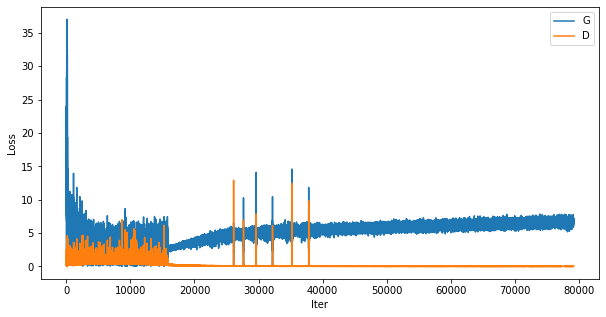

In [6]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

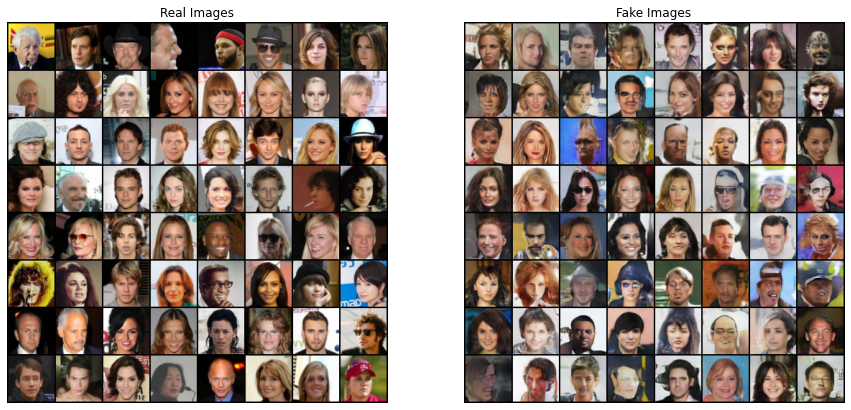

In [7]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()